<div style="text-align: center;">
  <a href="https://cognitiveclass.ai/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0321EN-SkillsNetwork/image/IDSN-logo.png" width="400">
  </a>
</div>


<h1 align=left><font size = 6>Lab: Vision Transformers Using Keras </font></h1>


<h5>Estimated time: 90 minutes</h5>


## Introduction

In this notebook, you will learn to build a CNN-Vision Transformer (ViT) hybrid image classification model. You will start by loading an existing CNN that is good at recognizing small patterns in pictures. Then, you'll learn how to improve it with a transformer, which helps the model see and use wider and more complex relationships in an image. The notebook covers important topics like preparing your image data, making your model smarter with both local and global learning, and saving your best results automatically. By the end, you'll understand how CNN-ViT hybrid models work and how to train, evaluate, and visualize them for any image classification task.


<h2>Objective</h2>

This notebook demonstrates how to use a custom-trained Keras CNN model to extract feature maps and feed them into a ViT architecture.

After completing this lab, you will be able to:
<ul>
    
1. Load the custom-trained CNN model
2. Extract feature maps from the CNN
3. Prepare tokens for the Vision Transformer
4. Build the Vision Transformer encoder
5. Train and evaluate the combined model

</ul>


## Table of contents

<font size = 3> 
    
1. [ Custom positional embedding layer](#Custom-positional-embedding-layer)
3. [Transformer block implementation](#Transformer-block-implementation)
4. [Hybrid model builder function](#Hybrid-model-builder-function)
5. [Model loading and setup](#Model-loading-and-setup)
6. [Data generator configuration](#Data-generator-configuration)
7. [Model checkpoint setup](#Model-checkpoint-setup)
8. [Model training and compilation](#Model-training-and-compilation)
9. [Model shape validation](#Model-shape-validation)
10. [Training results visualization](#Training-results-visualization)

</font> 


## Data download and extraction
Let's begin by downloading the dataset to evaluate the models.
Here, you declare:
1. The dataset URL from which the dataset would be downloaded
2. The dataset downloading primary function, based on the `skillsnetwork` library
3. The dataset fallback downloading function, based on regular `http` downloading functions


In [3]:
import os
import skillsnetwork

data_dir = "."
dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4Z1fwRR295-1O3PMQBH6Dg/images-dataSAT.tar"


def check_skillnetwork_extraction(extract_dir):
    """Check if the environment allows symlink creation for download/extraction."""
    symlink_test = os.path.join(extract_dir, "symlink_test")
    if not os.path.exists(symlink_test):
        os.symlink(os.path.join(os.sep, "tmp"), symlink_test)
        print("Write permissions available for downloading and extracting the dataset tar file")
        os.unlink(symlink_test)

async def download_tar_dataset(url, tar_path, extract_dir):
    """Download and extract dataset tar file asynchronously."""
    if not os.path.exists(tar_path):
        try:
            print(f"Downloading from {url}...")
            import httpx
            async with httpx.AsyncClient() as client:
                response = await client.get(url, follow_redirects=True)
                response.raise_for_status()
                with open(tar_path, "wb") as f:
                    f.write(response.content)
            print(f"Successfully downloaded '{tar_path}'.")
        except Exception as e:
            print(f"Download error: {e}")
    else:
        print(f"Dataset tar file already exists at: {tar_path}")
    import tarfile
    with tarfile.open(tar_path, 'r:*') as tar_ref:
        tar_ref.extractall(path=extract_dir)
        print(f"Successfully extracted to '{extract_dir}'.")

try:
    check_skillnetwork_extraction(data_dir)
    await skillsnetwork.prepare(url=dataset_url, path=data_dir, overwrite=True)
except Exception as e:
    print(e)
    print("Primary download/extraction method failed.")
    print("Falling back to manual download and extraction...")
    import tarfile
    import httpx
    from pathlib import Path
    file_name = Path(dataset_url).name
    tar_path = os.path.join(data_dir, file_name)
    await download_tar_dataset(dataset_url, tar_path, data_dir)

Write permissions available for downloading and extracting the dataset tar file


  0%|          | 0/6003 [00:00<?, ?it/s]

Saved to '.'


## Package installation

Install the required basic Python packages.


In [4]:
%%time
%%capture captured_output
%pip install numpy==1.26
%pip install matplotlib==3.9.2
%pip install skillsnetwork

CPU times: user 41.1 ms, sys: 31 ms, total: 72 ms
Wall time: 10.1 s


### Install Tensorflow library for Keras


In [5]:
%%time
%pip install tensorflow==2.19

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 104.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 9.5 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 6.0 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 55.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
CPU times: user 1.42 s, sys: 361 ms, total: 1.78 s
Wall time: 1min 31s


### Install SkLearn ML library for evaluation metrics


In [6]:
%%time
%pip install scikit-learn==1.7.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 162.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 180.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
CPU times: user 114 ms, sys: 44.9 ms, total: 159 ms
Wall time: 8.79 s


## Library imports and setup

Import essential libraries for data manipulation and visualization, and suppress warnings for cleaner notebook output.


In [7]:
%%time
import warnings
warnings.filterwarnings('ignore')

import os
import time
import httpx
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
def present_time():
        return datetime.now().strftime('%Y%m%d_%H%M%S')



CPU times: user 566 ms, sys: 208 ms, total: 774 ms
Wall time: 867 ms


### TensorFlow/Keras library imports

Sets environment variables to reduce TensorFlow logging noise and imports Keras modules for model building and training. Detects GPU availability for device assignment.


In [8]:
%%time
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import ModelCheckpoint

gpu_list = tf.config.list_physical_devices('GPU')
device = "gpu" if gpu_list != [] else "cpu"
print(f"Device available for training: {device}")

E0000 00:00:1755855796.205764     289 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755855796.211854     289 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755855796.244274     289 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755855796.244295     289 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755855796.244297     289 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755855796.244299     289 computation_placer.cc:177] computation placer already registered. Please check linka

Device available for training: cpu
CPU times: user 2.62 s, sys: 379 ms, total: 3 s
Wall time: 3.59 s


## Model download helper

Now, define an asynchronous function to download model files from given URLs, if they are not already present locally. 
You use `httpx` for asynchronous HTTP requests with error handling.


In [9]:
async def download_model(url, model_path):
    if not os.path.exists(model_path):
        try:
            print(f"Downloading from {url}...")
            import httpx
            async with httpx.AsyncClient() as client:
                response = await client.get(url, follow_redirects=True)
                response.raise_for_status()
                with open(model_path, "wb") as f:
                    f.write(response.content)
            print(f"Successfully downloaded '{model_path}'.")
        except Exception as e:
            print(f"Download error: {e}")
    else:
        print(f"Model file already downloaded at: {model_path}")

## Lab layout
1. You will start by loading a pre-trained Convolutional Neural Network (CNN) to act as a robust feature extractor for your image dataset.
2. After loading your CNN, you’ll select an intermediate feature map and reshape it into a sequence of tokens, getting your data ready for transformer-based learning.
3. You’ll add custom positional embeddings to your tokens so that the model can retain the original spatial structure of your images, even after the features have been flattened.
4. Next, you implement a Vision Transformer (ViT) encoder by stacking several transformer blocks, allowing your model to learn global relationships and context throughout the image.
5. You’ll combine the CNN and ViT encoder into a single, hybrid model so that you can leverage both the local feature extraction power of CNNs and the global attention mechanism of transformers.
6. When preparing your dataset, you’ll use Keras’s ImageDataGenerator to handle data augmentation and to properly encode your labels for multi-class image classification.
7. You’ll set up a model checkpoint callback, letting your model automatically save its best weights whenever validation accuracy improves during training, so you always keep the most effective model.
8. To ensure everything works smoothly, you’ll check the input and output shapes, which helps you catch architectural mistakes early.
9. As your model trains, you’ll visualize both training and validation accuracy and loss, which will help you monitor performance and spot signs of overfitting or underfitting.
10. Throughout the process, you can follow clear explanations in the notebook, making it easy for you to understand how each component—from CNN to transformer—is integrated to achieve stronger image classification.


## Model paths and download

In the cell below, you define the file paths and URLs for the Keras and PyTorch models and download them using the `download_model` function defined above.


In [10]:
data_dir = "."

keras_model_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/U-uPeyCyOQYh0GrZPGsqoQ/ai-capstone-keras-best-model-model.keras"
keras_model_name = "ai-capstone-keras-best-model-model_downloaded.keras"
keras_model_path = os.path.join(data_dir, keras_model_name)

await download_model(keras_model_url, keras_model_path)

Model file already downloaded at: ./ai-capstone-keras-best-model-model_downloaded.keras


### Reproducibility with random seeds

Here we fix the random seeds for `random` module, NumPy, and TensorFlow. By initializing these seeds with a constant value (for example, 42), any operations that involve randomness (such as weight initialization, data shuffling, or data augmentation) will produce the exact same sequence of random numbers every time the code is run. This is crucial for ensuring the reproducibility of experimental results and when comparing different models or hyperparameters.


In [11]:
# Set seed for reproducibility
seed_value = 7331
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## Model loading and setup

Here, you will load a pre-trained CNN model and learn to work with saved Keras models and prepare them for use in the hybrid architecture.


## Task 1: Load the pre-trained CNN model in `cnn_model` variable using `load_model()` function and print model summary using `summary()` method

The `load_model()` function loads the complete Keras model, including architecture, weights, and compilation state. The loaded model serves as the CNN backbone for feature extraction in the hybrid architecture. The `cnn_model.summary()` line can be uncommented to inspect the model architecture and identify appropriate layers for feature extraction.


In [12]:
## Please use the space below to write your answer
cnn_model = load_model(keras_model_path) # Loading the CNN model
cnn_model.summary() # Display model summary

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 512)      │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 1024)     │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 1, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 61,034,501 (232.83 MB)

 Trainable params: 20,340,801 (77.59 MB)

 Non-trainable params: 12,096 (47.25 KB)

 Optimizer params: 40,681,604 (155.19 MB)

Double-click **here** for the solution.
<!--
cnn_model = load_model(keras_model_path) # Loading the CNN model

cnn_model.summary() # Display model summary
-->


## Task 2: Based on `model.summary()`, get the name of the layer from the CNN model for feature extraction in the variable `feature_layer_name`

This is the last convolutional layer, usually before `GlobalAveragePooling2D`.


In [13]:
feature_layer_name = "batch_normalization_5"



Double-click **here** for the solution.
<!--
feature_layer_name = "batch_normalization_5"
-->


## Custom positional embedding layer

In this cell, you define a custom Keras layer called `AddPositionEmbedding` that implements positional embeddings for the Vision Transformer architecture. Positional embeddings are crucial in transformer models because they lack inherent spatial awareness, unlike convolutional layers that have built-in spatial inductive biases.

- The class inherits from `layers.Layer`, making it a proper Keras custom layer
- In the `__init__` method, it creates a trainable weight matrix using `self.add_weight()`
- The positional embedding has shape `(1, num_patches, embed_dim)` where the first dimension allows broadcasting across batch sizes
- The `initializer="random_normal"` ensures the embeddings start with random values that will be learned during training
- The `trainable=True` parameter makes these embeddings learnable parameters


This layer is essential for the hybrid CNN-ViT architecture because when CNN feature maps are flattened into tokens, spatial relationships are lost. The positional embeddings restore spatial awareness by providing each token with information about its original spatial location in the feature map. This allows the transformer to understand which tokens are spatially adjacent or distant, enabling it to make spatially aware attention decisions.

The `call` method adds the positional embeddings to the input tokens using element-wise addition. This is computationally efficient and follows the standard transformer approach, where positional information is added to preserve the embedding dimension.


In [14]:
# Positional embedding that Keras can track
@tf.keras.utils.register_keras_serializable(package="Custom")
class AddPositionEmbedding(layers.Layer):
    def __init__(self, num_patches, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.embed_dim   = embed_dim
        self.pos = self.add_weight(
            name="pos_embedding",
            shape=(1, num_patches, embed_dim),
            initializer="random_normal",
            trainable=True)

    def call(self, tokens):
        return tokens + self.pos

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "embed_dim":   self.embed_dim,
        })
        return {**config}

## Transformer block implementation

In this code cell, you will implement a complete transformer encoder block, the fundamental building block of the Vision Transformer architecture. The `TransformerBlock` class encapsulates the standard transformer encoder architecture with multi-head self-attention and feed-forward neural network components.

**Role in hybrid architecture:**
In the CNN-ViT hybrid, these transformer blocks process the tokenized CNN feature maps, allowing the model to capture long-range spatial dependencies that CNNs might miss due to their limited receptive fields. The self-attention mechanism enables each spatial location to attend to all other locations, providing global context awareness.

**Technical architecture:**
- **Multi-head attention (MHA):** Uses `layers.MultiHeadAttention` with a configurable number of heads and key dimension equal to embed_dim
- **Layer normalization:** Two `LayerNormalization` layers with epsilon=1e-6 for numerical stability
- **MLP block:** A two-layer feed-forward network with GELU activation and dropout for regularization
- **Residual connections:** Implements skip connections around both the attention and MLP blocks

**Parameters:**
- `embed_dim`: The dimensionality of token embeddings (typically matches CNN feature map channels)
- `num_heads`: Number of attention heads (default 8, must divide embed_dim evenly)
- `mlp_dim`: Hidden dimension of the MLP block (typically 4x embed_dim)
- `dropout`: Dropout rate for regularization (default 0.1)

**Forward pass logic:**
Forward pass allows the model to capture both local and global dependencies in the feature representations while maintaining gradient flow through residual connections.


In [15]:
# One Transformer encoder block
@tf.keras.utils.register_keras_serializable(package="Custom")
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads=8, mlp_dim=2048, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim   = mlp_dim
        self.dropout   = dropout
        self.mha  = layers.MultiHeadAttention(num_heads, key_dim=embed_dim)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = tf.keras.Sequential([
            layers.Dense(mlp_dim, activation="gelu"),
            layers.Dropout(dropout),
            layers.Dense(embed_dim),
            layers.Dropout(dropout)
        ])

    def call(self, x):
        x = self.norm1(x + self.mha(x, x))
        return self.norm2(x + self.mlp(x))

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim":  self.embed_dim,
            "num_heads":  self.num_heads,
            "mlp_dim":    self.mlp_dim,
            "dropout":    self.dropout,
        })
        return {**config}


## Hybrid model builder function

Now, you will define a function `build_cnn_vit_hybrid` that constructs the complete hybrid CNN-Vision Transformer model. This function represents the main architectural innovation of the notebook, combining the strengths of convolutional neural networks for local feature extraction with transformers for global context modeling.

**Function architecture:**
1. **CNN feature extraction:** Extracts intermediate feature maps from a pre-trained CNN at a specified layer
2. **Tokenization:** Reshapes spatial feature maps into a sequence of tokens suitable for transformer processing
3. **Positional encoding:** Adds learnable positional embeddings to maintain spatial relationships
4. **Transformer stack:** Applies multiple transformer encoder blocks for global context modeling
5. **Classification head:** Pools tokens and applies the final classification layer

**Parameters:**
- `cnn_model`: Pre-trained CNN model for feature extraction
- `feature_layer_name`: Name of the CNN layer to extract features from (e.g., `batch_normalization_5` in the original model architecture)
- `num_transformer_layers`: Number of transformer blocks to stack (default 4)
- `num_heads`: Number of attention heads per transformer block (default 8)
- `mlp_dim`: MLP hidden dimension in transformer blocks (default 2048)
- `num_classes`: Number of output classes for classification

The function first freezes the CNN backbone (`cnn_model.trainable = False`) to use it as a fixed feature extractor. It then extracts feature maps with shape (B, H, W, C) and reshapes them to (B, H*W, C), where each spatial location becomes a token. The `AddPositionEmbedding` layer adds spatial awareness, and multiple TransformerBlock layers process the tokens. Finally, `GlobalAveragePooling1D` aggregates all tokens, and a dense layer with softmax activation produces class predictions.

This hybrid approach leverages CNN's local feature detection capabilities while adding the transformer's global attention mechanism. The result is a model that can capture both fine-grained local patterns and long-range spatial dependencies, potentially **outperforming pure CNN** or pure transformer approaches on vision tasks.


In [16]:
def build_cnn_vit_hybrid(
        cnn_model,
        feature_layer_name,
        num_transformer_layers=4,
        num_heads=8,
        mlp_dim=2048,
        num_classes=3):
    # 1. Freeze or fine-tune the CNN as you prefer
    cnn_model.trainable = False      # set True to fine-tune
    
    # 2. Feature extractor up to the chosen layer
    features = cnn_model.get_layer(feature_layer_name).output
    H, W, C = features.shape[1], features.shape[2], features.shape[3]
    
    # 3. Flatten spatial grid → tokens  &  add positional encoding
    x = layers.Reshape((H * W, C))(features) 
    x = AddPositionEmbedding(H * W, C)(x)

    # 4. Stack ViT encoder blocks
    for _ in range(num_transformer_layers):
        x = TransformerBlock(C, num_heads, mlp_dim)(x)

    # 5. Token pooling & classification head
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return Model(cnn_model.layers[0].input, outputs, name="CNN_ViT_hybrid")


## Data generator configuration

Now you will set up data preprocessing and augmentation pipeline using Keras' `ImageDataGenerator`.

**Data configuration parameters:**
- `img_w, img_h = 64, 64`: Input image dimensions (64x64 pixels)
- `n_channels = 3`: RGB color channels
- `batch_size = 128`: Number of samples per training batch
- `num_classes = 2`: Binary classification setup

**Generators:**
Two separate generators are created:
1. `train_gen`: Training data with augmentation and shuffling
2. `val_gen`: Validation data with the same preprocessing but a different subset

Both generators use `class_mode="categorical"` for one-hot encoded labels, `target_size=(64,64)` for consistent input dimensions, and `shuffle=True` for randomized batch sampling.

This augmentation strategy significantly increases the effective dataset size and helps prevent overfitting by exposing the model to varied versions of the same images. The validation split ensures proper model evaluation on unseen data, while the categorical class mode prepares labels for softmax classification in the hybrid model.


In [17]:
dataset_path = os.path.join(data_dir, "images_dataSAT")
print(dataset_path)

img_w, img_h = 64, 64
n_channels = 3
batch_size = 32
num_classes = 2


datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=40, 
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode="nearest",
                             validation_split=0.2
                            )

train_gen = datagen.flow_from_directory(dataset_path,
                                        target_size = (img_w, img_h),
                                        batch_size= batch_size,
                                        class_mode="categorical",
                                        subset="training",
                                        shuffle=True
                                       )

val_gen = datagen.flow_from_directory(dataset_path,
                                      target_size =(img_w, img_h),
                                      batch_size = batch_size, 
                                      class_mode="categorical",
                                      subset="validation",
                                      shuffle=True
                                     )


./images_dataSAT
Found 4800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


## Model checkpoint setup

This code cell configures a `ModelCheckpoint` callback for saving the best model weights during training. Model checkpointing is a crucial practice in deep learning that prevents loss of training progress and enables recovery of the best-performing model state.

**Checkpoint configuration:**
- `filepath`: Specifies the file path and name for saving weights
- `save_weights_only=True`: Saves only model weights, not the full model architecture (more efficient and avoids serialization issues)
- `monitor='val_accuracy'`: Tracks validation accuracy as the metric for determining the "best" model
- `mode='max'`: Indicates that higher validation accuracy values are better (use 'min' for loss metrics)
- `save_best_only=True`: Only saves the model when validation accuracy improves, preventing storage of worse-performing checkpoints
- `verbose=1`: Provides console output when a checkpoint is saved

The checkpoint callback addresses several important training considerations:
1. **Overfitting prevention:** Captures the model state at peak validation performance before overfitting occurs
2. **Storage efficiency:** Saving weights only reduces file size compared to full model serialization
3. **Automatic model saving:** Eliminates manual monitoring by automatically saving the best-performing epoch

**Integration with training:**
This callback will be passed to the `model.fit()` method, where it will monitor validation accuracy after each epoch. When validation accuracy improves, the callback saves the current model weights to the specified file. This ensures that even if training continues past the optimal point, the best-performing weights are preserved.

**File naming convention:**
The filename uses the `.model.keras` extension to indicate it contains the full model architecture.


In [18]:
class CustomPrintCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        # Print epoch number and starting time
        print(f"Epoch {(epoch + 1):02d} completed on {present_time()}")
time_print_callback = CustomPrintCallback()

In [19]:
model_name = "keras_cnn_vit.model.keras"
# Save only weights to overcome the serialization issues with the hybrid model. The full model can be saved using the model architecture and weights.
checkpoint_cb = ModelCheckpoint(filepath=model_name,
                                save_weights_only=False,  # Set to True to save only weights
                                monitor='val_loss',      # or 'val_accuracy', 'val_loss'
                                mode='min',              # 'min' for loss, 'max' for accuracy
                                save_best_only=True,
                                verbose=1
                                
                               )

## Model training and compilation

Now, you will set up the core training pipeline, where the hybrid CNN-ViT model is built, compiled, and trained. This is the complete workflow from model instantiation to training execution with proper configuration for multi-class classification.


## Task 3: Define the model architecture in a variable named `hybrid_model` using the `build_cnn_vit_hybrid` function
You may use the following parameters:

- feature_layer_name: "batch_normalization_5"
- num_transformer_layers: 4
- attention heads: 2
- mlp dimension: 2048
    


In [20]:
num_classes = train_gen.num_classes  # automatic
hybrid_model = build_cnn_vit_hybrid(
    cnn_model,
    feature_layer_name="batch_normalization_5",
    num_transformer_layers=4,
    num_heads=2,
    mlp_dim=2048,
    num_classes=num_classes
)


Double-click **here** for the solution.
<!--

num_classes = train_gen.num_classes  # automatic
hybrid_model = build_cnn_vit_hybrid(
        cnn_model,
        feature_layer_name="batch_normalization_5",
        num_transformer_layers=4,
        num_heads=8,
        mlp_dim=2048,
        num_classes=num_classes)

-->


## Task 4: Compile the model `hybrid_model` 

You may use the following parameters:
- `optimizer=tf.keras.optimizers.Adam`
- `learning rate: 0.0001`
- `loss: categorical_crossentropy`
- `metrics: accuracy`


In [21]:
hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                     loss="categorical_crossentropy",
                     metrics=["accuracy"],
                    )

Double-click **here** for the solution.
<!--
hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                     loss="categorical_crossentropy",
                     metrics=["accuracy"],
                    )
-->


## Model shape validation

This code cell performs the validation step to ensure the hybrid model produces outputs with the correct shape and dimensions. Shape validation is essential in deep learning to catch architectural errors early and verify that the model will work correctly with the expected input and output formats.

**Validation process:**
The cell creates a dummy input tensor using `tf.random.normal([1, img_w, img_h, n_channels])`, which generates random values with the same shape as actual input images:
- Batch size: 1 (single sample for testing)
- Width: `img_w` (64 pixels)
- Height: `img_h` (64 pixels)
- Channels: `n_channels` (3 for RGB)

**Output verification:**
The dummy input is passed through the hybrid model (`hybrid_model(dummy)`) to generate predictions. The expected output shape should be `(1, num_classes)` where:
- First dimension (1): Batch size
- Second dimension (`num_classes`): Number of classification classes

**Technical benefits:**
This validation step serves multiple purposes:
1. **Architecture verification:** Confirms that all layers are properly connected and compatible
2. **Dimension checking:** Ensures the model produces the expected output shape for classification
3. **Early error detection:** Catches shape mismatches before actual training or inference
4. **Model readiness:** Verifies the model is ready for production use

**Importance:**
If the output shape doesn't match expectations, it indicates potential issues in the hybrid architecture, such as incorrect reshaping operations, wrong number of classes configuration, or problems in the CNN-to-transformer transition. This simple test can save significant debugging time by catching architectural issues immediately after model construction.


In [22]:
# Ensure end-to-end shapes line up
dummy = tf.random.normal([1, img_w, img_h, n_channels])
pred  = hybrid_model(dummy)
print("Logits shape:", pred.shape)   # should be (1, num_classes)


Logits shape: (1, 2)


## Task 5: Define the training configuration of the `hybrid_model`.
Train for 3 epochs
Use the `checkpoint_cb` callback keyword for automatic saving of the best model state.


In [23]:
fit = hybrid_model.fit(train_gen,
                       epochs=3,
                       validation_data=val_gen,
                       callbacks=[checkpoint_cb],
                        )

Epoch 1/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9956 - loss: 0.0697   
Epoch 1: val_loss improved from None to 0.09445, saving model to keras_cnn_vit.model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 1659s 11s/step - accuracy: 0.9948 - loss: 0.0565 - val_accuracy: 0.9900 - val_loss: 0.0944
Epoch 2/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9892 - loss: 0.0651   
Epoch 2: val_loss improved from 0.09445 to 0.03939, saving model to keras_cnn_vit.model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 1666s 11s/step - accuracy: 0.9919 - loss: 0.0502 - val_accuracy: 0.9933 - val_loss: 0.0394
Epoch 3/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9914 - loss: 0.0362   
Epoch 3: val_loss did not improve from 0.03939
150/150 ━━━━━━━━━━━━━━━━━━━━ 1638s 11s/step - accuracy: 0.9925 - loss: 0.0289 - val_accuracy: 0.9867 - val_loss: 0.0512


Double-click **here** for the solution.
<!--

fit = hybrid_model.fit(train_gen,
                       epochs=3,
                       validation_data=val_gen,
                       callbacks=[checkpoint_cb],
                        )
-->


## Training results visualization

This code cell creates comprehensive visualizations of the training process by plotting both accuracy and loss curves. Visualization of training metrics is essential for understanding model performance, diagnosing training issues, and making informed decisions about model optimization.

**Visualization setup:**
The cell uses matplotlib to create two separate plots with consistent styling:
- `fig_w, fig_h`: Sets figure dimensions for compact, readable plots
- `plt.subplots(figsize=(fig_w, fig_h))`: Creates a subplot with specified dimensions

**Accuracy plot analysis:**
The first plot displays training and validation accuracy over epochs:
- `fit.history['accuracy']`: Training accuracy progression
- `fit.history['val_accuracy']`: Validation accuracy progression

**Loss plot analysis:**
The second plot shows training and validation loss curves:
- `fit.history['loss']`: Training loss progression
- `fit.history['val_loss']`: Validation loss progression

***Importance:***
These plots enable several important analyses:
1. **Overfitting detection:** Diverging training and validation curves indicate overfitting
2. **Convergence assessment:** Plateauing curves suggest training completion
3. **Learning rate evaluation:** Oscillating curves may indicate learning rate issues
4. **Model performance:** Final accuracy and loss values indicate overall model quality


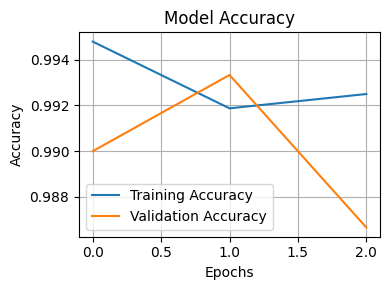

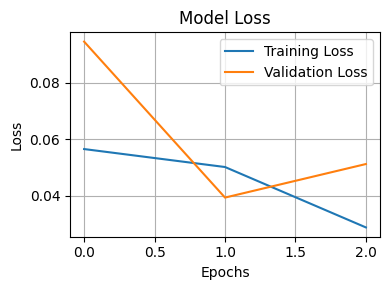

In [24]:
# Create a figure with a subplot
fig_w, fig_h = 4,3
fig, axs = plt.subplots(figsize=(fig_w, fig_h ))

# Plot Accuracy on the first subplot
axs.plot(fit.history['accuracy'], label='Training Accuracy')
axs.plot(fit.history['val_accuracy'], label='Validation Accuracy')
axs.set_title('Model Accuracy')
axs.set_xlabel('Epochs')
axs.set_ylabel('Accuracy')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()


## You can use this cell to type the code to complete the task.

fig, axs = plt.subplots(figsize=(fig_w, fig_h ))

# Plot Loss on the second subplot
axs.plot(fit.history['loss'], label='Training Loss')
axs.plot(fit.history['val_loss'], label='Validation Loss')
axs.set_title('Model Loss')
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

## Save and download the trained model weights

You have successfully trained the ViT model for classification of agricultural land from satellite imagery using **Keras**
In this lab, in the interest of time, you have trained the model for 3-5 epochs. However, usually you need to train the model for around 15-20 epochs, depending on the quality of training data and model metrics based on validation. 

For your convenience, I have saved a model state dict for the model trained over 20 epochs **[here](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/7uNMQhNyTA8qSSDGn5Cc7A/keras-cnn-vit-ai-capstone.keras)**. You can download that for evaluation and further labs on your local machine from **[this link](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/7uNMQhNyTA8qSSDGn5Cc7A/keras-cnn-vit-ai-capstone.keras)**.


Otherwise, you have also saved the model state dictionary for the best model using the `checkpoint_cb` callback function during training in this lab.

You can also download the model state dict for the model that you have just trained for use in the subsequent labs.

This is the PyTorch AI model state that can now be used for infering un-classified images. 

- You can download the trained model weights: `keras_cnn_vit.model.keras` from the left pane and save it on your local computer. 
- You can download this model by "right-click" on the file and then Clicking "Download".
- In conjunction with the model architecture, these model weights can be used in other labs of this AI capstone course, instead of the weights provided at the above link


## Save and download the notebook for **final project** submission and evaluation

You will need to save and download the completed notebook for final project submission and evaluation. 
<br>For saving and downloading the completed notebook, please follow the steps given below:</br>

<font size = 4>  

1) **Complete** all the tasks and questions given in the notebook.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/nv4jHlPU5_R1q7ZJrZ69eg/DL0321EN-M1L1-Save-IPYNB-Screenshot-1.png" style="width:600px; border:0px solid black;">

2) **Save** the notebook.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9-WPWD4mW1d-RV5Il5otTg/DL0321EN-M1L1-Save-IPYNB-Screenshot-2.png" style="width:600px; border:0px solid black;">

3) Identify and right click on the **correct notebook file** in the left pane.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/RUSRPw7NT6Sof94B7-9naQ/DL0321EN-M1L1-Save-IPYNB-Screenshot-3.png" style="width:600px; border:0px solid black;">

4) Click on **Download**.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/HHry4GT-vhLEcRi1T_LHGg/DL0321EN-M1L1-Save-IPYNB-Screenshot-4.png" style="width:600px; border:0px solid black;">

5) Download and **Save** the Jupyter notebook file on your computer **for final submission**.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/hhsJbxc6R-T8_pXQGjMjvg/DL0321EN-M1L1-Save-IPYNB-Screenshot-5.png" style="width:600px; border:0px solid black;">
  </font>


## Conclusion

Congratulations! You've successfully built a CNN-ViT hybrid image classification model.
In this lab, you learnt how to combine a convolutional neural network (CNN) with a Vision Transformer (ViT) for advanced image classification tasks. Starting from a pre-trained CNN, you learnt how to extract intermediate features, reshape them as tokens, and provide them with positional embeddings. By stacking transformer encoder blocks on top, the model benefits from both local detail extraction and global context awareness. Throughout the lab, techniques for robust data preparation, efficient training with model checkpoints, and effective visualization of performance were covered. By completing the steps in this notebook, you now have hands-on experience implementing and evaluating a contemporary hybrid vision model using Keras.


<h2>Author</h2>

[Aman Aggarwal](https://www.linkedin.com/in/aggarwal-aman)

Aman Aggarwal is a PhD working at the intersection of neuroscience, AI, and drug discovery. He specializes in quantitative microscopy and image processing.



<!--
## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2025-07-14  | 1.0  | Aman  |  Created the lab |

-->


© Copyright IBM Corporation. All rights reserved.
